# Word Embeddings

In this notebook, we will use word embeddings to perform searches based on movie descriptions in ArangoDB. 

We'll start by breaking down how to convert a string into a set of word embeddings produced by a state-of-the-art Transformer model. Then we'll use a higher-level API to create embeddings and compare them so that you can see their expressive power!
Finally, we'll create embeddings for movie descriptions in our IMDb graph and perform similarity searches and query-based searches.

## Introduction to Word Embeddings

Transforming text so that it can be used efficiently and processed correctly by computers has long been an open problem in Natural Language Processing (NLP). Word embeddings are a development that has been considered a breakthrough in this area. If you've ever used voice assistants such as Amazon Alexa or Siri, a translation service such as Google Translate, or a search engine - you've come into contact with applications of word embeddings! 


Now you might be wondering: What is a word embedding?

Word embeddings are a numerical representation of text, consisting of ordered sequences of numbers called vectors. The intuition behind these embeddings is that words that appear in similar contexts and share similar meanings should have similar embeddings. In practice, these representations are vectors that are calculated based on the setting that they are in. These vectors are unique per word, so if we were to retrieve the embedding for `king`, it would have a different embedding than `man`. Since these embeddings contain a representation of meaning, we can also use them to do approximate math. For example, if we do `king - man + woman`, we will end up with a vector that is close to the `queen` word embedding. It's important to note that the context matters. This effect is most pronounced if your text contains homonyms. Homonyms are words that have the same spelling but different meanings. For example, `address` has a different meaning in the following sentences:
 
 ```"He was about to address the congregation."```

 ```"I would like to update my current address."```

In this case, the word embedding you would compute for the word `address` will differ per sentence (provided you are using a recent embedding model).


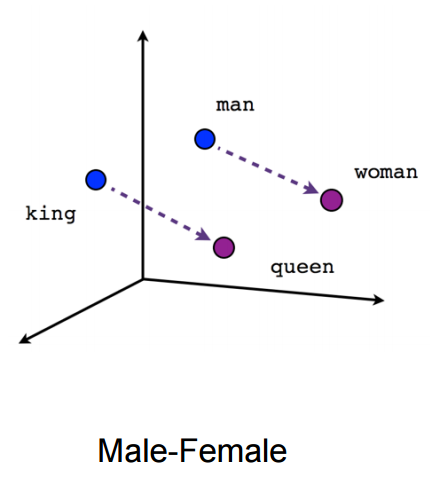

[From [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space)]

These embeddings are created by training a neural network model to predict the context around a target word (the target word is the one we're trying to make an embedding for). The first word embedding models used a sliding window around the target word as the relevant context. An example of a sliding window around `"fox"` can be seen below:

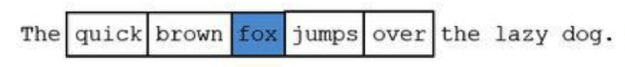

[Example of a sliding window. From Wittum, Gabriel & Hoffer, Michael & Lemke, Babett & Jabs, Robert & Naegel, Arne. (2020). Automated methods for the comparison of natural languages. Computing and Visualization in Science. 23. 10.1007/s00791-020-00325-2.]

Recently, research has yielded a new mechanism for taking context into account: Attention. Attention is a mechanism that allows a model to focus on the relevant parts of an input text as needed. The idea of attention stems from the notion that all the words used in a sentence are interconnected, and the model should use those hidden connections at the appropriate time to link words together. These connections can span entire sentences (and, in some cases, even paragraphs), so they aren't limited to a single sliding window, dramatically increasing the expressive power of these representations. 
 

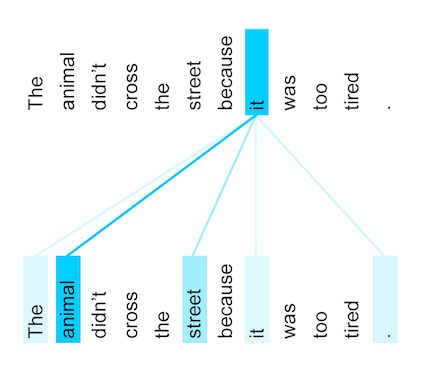

[An example of attention in a sentence. From the [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)]

Here we can see an example of attention in action. The attention mechanism correctly places a higher emphasis on "animal" when calculating the attention for the word "it" in the sentence.

The first model that introduced this (and afterward spawned a whole host of improvements) is known as a Transformer. It has managed to achieve state-of-the-art results for tasks related to word embeddings such as [Language Modeling](https://en.wikipedia.org/wiki/Language_model). 


The building block of a Transformer model is known as multi-headed attention, which is a set of multiple attention layers applied in parallel to the same input. This allows the model to pay attention to different aspects of the input text simultaneously. Multiple multi-headed attention blocks are stacked on top of one another until we reach a final representation for each word in the input text. This may seem difficult to understand, but don't worry! We've included an interactive visualization of multi-headed attention in the tutorial below.

<img src="https://www.researchgate.net/publication/334288604/figure/download/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width=250 alt="Transformer model">

[The internals of a Transformer embedding model. From Castellucci, Giuseppe & Bellomaria, Valentina & Favalli, Andrea & Romagnoli, Raniero. (2019). Multi-lingual Intent Detection and Slot Filling in a Joint BERT-based Model.]

The representations produced by these models will be the core focus of this notebook. If you would like a more in-depth visual explanation of word embeddings and Transformer models you can read these excellent posts by Jay Lammar: [Illustrated Word2Vec](https://jalammar.github.io/illustrated-word2vec/) and [Illustrated Transformers](https://jalammar.github.io/illustrated-transformer/). 

Once a word embedding model such as a Transformer has been trained on a large dataset, typically consisting of millions of sentences, the embeddings are ready for use in downstream tasks. 

This notion of "train once - use everywhere" is a concept called Transfer Learning. By pre-training embeddings on a large corpus, the resultant embeddings are well-generalized and are effective in various settings. In this notebook, we'll be using pre-trained embeddings when calculating our movie similarities.

However, it is important to note that there is no such thing as one size fits all, as different domains use words in different contexts with different meanings. To address this, you can apply what is known as fine-tuning - which is a process where you take the pre-trained model and train it further on a corpus for your specific application. We won't be going into further detail here, but if you would like to learn more, here are some resources to get you started: 

* https://medium.com/skilai/language-model-fine-tuning-for-pre-trained-transformers-b7262774a7ee
* https://huggingface.co/transformers/training.html

# Setup

In [ ]:
## WINDOWS

!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!xcopy .\interactive_tutorials\* . /E

!git clone -b imdb_complete --single-branch https://github.com/arangodb/interactive_tutorials.git imdb_complete
!xcopy .\imdb_complete\data\imdb_dump .\imdb_dump\ /E

## MAC AND LINUX

# !git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
# !rsync -av interactive_tutorials/ ./ --exclude=.git
# !chmod -R 755 ./tools
# !git clone -b imdb_complete --single-branch https://github.com/arangodb/interactive_tutorials.git imdb_complete
# !rsync -av imdb_complete/data/imdb_dump/ ./imdb_dump/

In [ ]:
%%capture
!pip3 install torch
!pip3 install transformers
!pip3 install pyarango
!pip3 install pandas
!pip3 install "python-arango>=5.0"

In [ ]:
import itertools
import json
import requests
import oasis
import time
import textwrap
from tqdm.notebook import tqdm

from pyArango.connection import *
from arango import ArangoClient

import torch
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
import numpy as np
import sys
from functools import partial
import os
import tritongrpcclient
import tritongrpcclient.model_config_pb2 as mc
import tritonhttpclient
from tritonclientutils import triton_to_np_dtype
from tritonclientutils import InferenceServerException
from transformers import AutoTokenizer
import torch
from torch.nn import functional as F

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
VERBOSE = False

Let's try with some random input sentence and extracts its sentence embeddings from the sentence bert model deployed on Triton server

In [ ]:
sentence = ['Who are you voting for 2021']
input_name = ['input__0', 'input__1']
output_name = 'output__0'

In [ ]:
len(sentence)

# Client-Side Script to Interact with Triton Inference Server 

run_inference function recieves sentence as an input, preprocess it (i.e. perform tokenization), hit the server with a preporcessed inputs and get back the embeddings from the triton server.

In [ ]:
def run_inference(sentence, model_name='sentence_bert', url='127.0.0.1:8000', model_version='1'):
    triton_client = tritonhttpclient.InferenceServerClient(
        url=url, verbose=VERBOSE)
    model_metadata = triton_client.get_model_metadata(
        model_name=model_name, model_version=model_version)
    model_config = triton_client.get_model_config(
        model_name=model_name, model_version=model_version)
    # tokenizes the given input sentence
    # I have restricted the input sequence length to 256
    inputs = tokenizer.batch_encode_plus(sentence,
                                     return_tensors='pt', max_length=256,
                                     truncation=True, padding='max_length')
    
    input_ids = inputs['input_ids']
    input_ids = np.array(input_ids, dtype=np.int32)
    mask = inputs['attention_mask']
    mask = np.array(mask, dtype=np.int32)
    mask = mask.reshape(1, 256) 
    input_ids = input_ids.reshape(1, 256)
    # inputs are send as tritonhttpclient objects
    input0 = tritonhttpclient.InferInput(input_name[0], (1,  256), 'INT32')
    input0.set_data_from_numpy(input_ids, binary_data=False)
    input1 = tritonhttpclient.InferInput(input_name[1], (1, 256), 'INT32')
    input1.set_data_from_numpy(mask, binary_data=False)
    output = tritonhttpclient.InferRequestedOutput(output_name,  binary_data=False)
    response = triton_client.infer(model_name, model_version=model_version, inputs=[input0, input1], outputs=[output])
    # converting response obj into numpy array
    embeddings = response.as_numpy('output__0')
    # word embeddings
    embeddings = torch.from_numpy(embeddings)
    print("emebddings shape:", embeddings.shape)
    # getting the sentence representation by taking mean over the first dimension
    sentence_rep = embeddings.mean(dim=1)
    return sentence_rep

In [ ]:
sentence_rep = run_inference(sentence)
print('sentence_representation', sentence_rep.shape)

# ArangoDB Setup

Now that we have a better idea of Transformer word/sentence embedding models can aid us in text search and comparison, let's start to apply it to a graph. To do so we'll first need to configure our database and load the data.

Create the temporary database:

In [ ]:
# Retrieve tmp credentials from ArangoDB Tutorial Service
login = oasis.getTempCredentials(tutorialName="WordEmbeddings", credentialProvider="https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB")

# Connect to the temp database
# Please note that we use the python-arango driver as it has better support for ArangoSearch 
database = oasis.connect_python_arango(login)

In [ ]:
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])

Feel free to use the above URL to checkout the ArangoDB WebUI!

# Import IMDB Example Dataset

![imdb](https://github.com/arangodb/interactive_tutorials/blob/master/notebooks/img/IMDB_graph.png?raw=1)

Next we will import the [IMBD Example Dataset](https://github.com/arangodb/example-datasets/tree/master/Graphs/IMDB) which contains information about various movies, actors, directors, ... as a graph. 
**N.B.** the included arangorestore will only work on Linux or Windows systems, if you want to run this notebook on a different OS please consider using the appropriate arangorestore from the [Download area](https://www.arangodb.com/download-major/).

# Linux

In [ ]:
# MAC
# ! ./tools/macos/arangorestore -c none --server.endpoint http+ssl://{login["hostname"]}:{login["port"]} --server.username {login["username"]} --server.database {login["dbName"]} --server.password {login["password"]} --default-replication-factor 3  --input-directory "imdb_dump"        

# WINDOWS
# Open a terminal and navigate to the tools found in this project folder.
# Copy paste the output of the following print statement to restore the the dump to the temporary database
#
# **NOTE**: You may need to update the dump directory
print("arangorestore -c none --server.endpoint 'http+ssl://tutorials.arangodb.cloud:8529' --server.username " + login["username"] + " --server.database " + login["dbName"] + " --server.password " + login["password"] + " --default-replication-factor 3  --input-directory ./imdb_dump")


# Movie Description Embeddings

Start by retrieving all movies that we want to produce description embeddings for.

In [ ]:
import pandas as pd
cursor = database.aql.execute(
"""
FOR d IN imdb_vertices 
   FILTER d.type == "Movie"
   FILTER d.description != "No overview found."
   RETURN {
     _id: d._id,
     description: d.description
    }
"""
)
movie_descriptions = list(cursor)

# let's take this list of movie descriptions and put it in a dataframe for ease of use
movies_df = pd.DataFrame(movie_descriptions)
movies_df = movies_df.dropna()

In [ ]:
movies_df 

In [ ]:
# Now iterate over the descriptions and produce the sentence embeddings
batch_size = 1

all_embs = []

for i in tqdm(range(0, len(movies_df), batch_size)):
  descr_batch = movies_df.iloc[i:i+1].description.tolist()
  embs = run_inference(descr_batch)
  print('embs shape:', embs.shape)
  all_embs.append(embs)

all_embs = np.concatenate(all_embs)
movies_df.loc[:, "sent_emb"] = np.vsplit(all_embs, len(all_embs))
movies_df["sent_emb"] = movies_df["sent_emb"].apply(lambda x: x.squeeze().tolist())

In [ ]:
movies_df

Now let's upload these embeddings to our ArangoDB database in batches.

In [ ]:
#BATCH_SIZE = 250
movie_collection = database["imdb_vertices"]

for i in tqdm(range(0, len(movies_df), batch_size)):
  update_batch = movies_df.loc[i:i+batch_size, ["_id", "sent_emb"]].to_dict("records")
  movie_collection.update_many(update_batch)

# Similarity Search Using Embeddings

Once the embeddings have been uploaded, we can query the database and use these embeddings to find the most similar movies based on their description's embeddings!

In [ ]:
cursor = database.aql.execute(
"""
  FOR m in imdb_vertices
    FILTER m._id == "imdb_vertices/28685"
    RETURN { "title": m.title, "description": m.description }
""")

# Iterate through the result cursor
for doc in cursor:
  print(doc)

Here we're using the cosine similarity to retrieve the closest matches to Karate Killer based on the embeddings of their movie descriptions. We're calculating this metric based on the equation we previously mentioned above:
$$
 \frac{
  \sum\limits_{i=1}^{n}{a_i b_i}
  }{
      \sqrt{\sum\limits_{j=1}^{n}{a_j^2}}
      \sqrt{\sum\limits_{k=1}^{n}{b_k^2}}
  }
$$



Once we calculate the cosine similarities, we can then SORT the movies and return the top 10 most similar movies!

In [ ]:
cursor = database.aql.execute(
"""
LET descr_emb = (
  FOR m in imdb_vertices
    FILTER m._id == "imdb_vertices/28685"
    FOR j in RANGE(0, 767)
      RETURN TO_NUMBER(NTH(m.sent_emb,j))
)

LET descr_mag = (
  SQRT(SUM(
    FOR i IN RANGE(0, 767)
      RETURN POW(TO_NUMBER(NTH(descr_emb, i)), 2)
  ))
)

LET dau = (

    FOR v in imdb_vertices
    FILTER HAS(v, "sent_emb")

    LET v_mag = (SQRT(SUM(
      FOR k IN RANGE(0, 767)
        RETURN POW(TO_NUMBER(NTH(v.sent_emb, k)), 2)
    )))

    LET numerator = (SUM(
      FOR i in RANGE(0,767)
          RETURN TO_NUMBER(NTH(descr_emb, i)) * TO_NUMBER(NTH(v.sent_emb, i))
    ))

    LET cos_sim = (numerator)/(descr_mag * v_mag)

    RETURN {"movie": v._id, "title": v.title, "cos_sim": cos_sim}

    )

FOR du in dau
    SORT du.cos_sim DESC
    LIMIT 10
    RETURN {"movie": du.title, "cos_sim": du.cos_sim} 
""")



In [ ]:
# Iterate through the result cursor
for doc in cursor:
  print(doc)

# Next Steps


In this tutorial we've learned how to take unstructured text, and use it to perform similarity searches in ArangoDB. If you would like to continue learning more about ArangoDB, here are some next steps to get you started!

* [Get a 2 week free Trial with the ArangoDB Cloud](https://cloud.arangodb.com/home?utm_source=AQLJoin&utm_medium=Github&utm_campaign=ArangoDB%20University)
* [Download ArangoDB](https://www.arangodb.com/download-major/)
* [ArangoDB Training Center](https://www.arangodb.com/learn/)
* [Getting Started with ArangoDB - Udemy](https://www.udemy.com/course/getting-started-with-arangodb/)